# TensorRT

NVIDIA® TensorRT™, an SDK for high-performance deep learning inference, includes a deep learning inference optimizer and runtime that delivers low latency and high throughput for inference applications.


This session shares required codes to how you can take an existing ONNX model built with a deep learning framework and build a TensorRT engine using the provided parsers. The Developer Guide also provides step-by-step instructions for common user tasks such as creating a TensorRT network definition, invoking the TensorRT builder, serializing and deserializing, and how to feed the engine with data and perform inference.

Since runnning these code requires NVIDIA GPU, we used Google Colab. Please keep in mind (based on my experience) generating TensorRT worked based on which NVIDIA GPU you use. It means you cannot generate a TensorRT Engine on one GPU and use it in another GPU. 

### Install requried libraries in Google Colab

In [1]:
!pip install pycuda # install cuda
!pip install tensorrt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 9.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 78 kB 8.4 MB/s 
     |████████████████████████████████| 71 kB 11.0 MB/s 
  Created wheel for pycuda: filename=pycuda-2022.2.2-cp38-cp38-linux_x86_64.whl size=646530 sha256=4911b76afcbf4e690f72876e5ff0947db0d9abbcc968aa1ae3a2e0137f48574f
  Stored in directory: /root/.cache/pip/wheels/7b/41/0d/7cecb04af969d283ebe4a69579a8b2baec0d010a1ac4159f7e
  Created wheel for pytools: filename=pytools-2022.1.13-py2.py3-none-any.whl size=66024 sha256=e75dd9049a26abececd06ba67f857debd2d29e2a9f843fe029a6cc2c4186666d
  Stored in directory: /root/.cache/pip/wheels/b5/c1/bb/26ba70fb9d10f195249ef4e170a92ae83e7534e55b67786fd9
Successfully built pycuda pytools
Looking in indexes: https://pypi.

#### Import requried libraries

In [2]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import os
import argparse
import tensorrt as trt
import random
import argparse
import os

import numpy as np
import pycuda.autoinit
import pycuda.driver as cuda
import tensorrt as trt
import numpy as np
from PIL import Image

#### Define Constants

In [63]:
verbose = False
TRT_LOGGER = trt.Logger(trt.Logger.VERBOSE) if verbose else trt.Logger()
MAX_BATCH_SIZE = 1
input_name = 'input.1'
Input_shape = (3,256,256)
model_name = "model"
fp16 = False
int8 = False
dla_core = -1 
verbose = False
engine_path = '%s.trt' % model_name
dim = (256,256)

#### Load created ONNX model 

In [36]:
def load_onnx(model_name):
    """Read the ONNX file."""
    onnx_path = '%s.onnx' % model_name
    if not os.path.isfile(onnx_path):
        print('ERROR: file (%s) not found!  You might want to run yolo_to_onnx.py first to generate it.' % onnx_path)
        return None
    else:
        with open(onnx_path, 'rb') as f:
            return f.read()

In [37]:
onnx_data = load_onnx(model_name)

#### Set network input batch size.

In [38]:
def set_net_batch(network, batch_size):
    """Set network input batch size.

    The ONNX file might have been generated with a different batch size,
    say, 64.
    """
    if trt.__version__[0] >= '7':
        shape = list(network.get_input(0).shape)
        shape[0] = batch_size
        network.get_input(0).shape = shape
    return network

#### Build a TensorRT engine from ONNX.

In [45]:
def build_engine(model_name,do_fp16, do_int8, dla_core, verbose=False):
    print('Loading the ONNX file...')
    onnx_data = load_onnx(model_name)
    if onnx_data is None:
        return None

    TRT_LOGGER = trt.Logger(trt.Logger.VERBOSE) if verbose else trt.Logger()
    EXPLICIT_BATCH = [] if trt.__version__[0] < '7' else \
        [1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)]
    with trt.Builder(TRT_LOGGER) as builder, builder.create_network(*EXPLICIT_BATCH) as network, trt.OnnxParser(network, TRT_LOGGER) as parser:
        if do_int8 and not builder.platform_has_fast_int8:
            raise RuntimeError('INT8 not supported on this platform')
        if not parser.parse(onnx_data):
            print('ERROR: Failed to parse the ONNX file.')
            for error in range(parser.num_errors):
                print(parser.get_error(error))
            return None
        network = set_net_batch(network, MAX_BATCH_SIZE)


        print('Building the TensorRT engine.  This would take a while...')
        print('(Use "--verbose" or "-v" to enable verbose logging.)')
        # new API: build_engine() with builder config
        builder.max_batch_size = MAX_BATCH_SIZE
        config = builder.create_builder_config()
        config.max_workspace_size = 1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
        config.set_flag(trt.BuilderFlag.GPU_FALLBACK)
        profile = builder.create_optimization_profile()
        profile.set_shape(input_name, (MAX_BATCH_SIZE, Input_shape[0], Input_shape[1], Input_shape[2]),
                          (MAX_BATCH_SIZE, Input_shape[0], Input_shape[1], Input_shape[2]),(MAX_BATCH_SIZE, Input_shape[0], Input_shape[1], Input_shape[2]))
        config.add_optimization_profile(profile)
        engine = builder.build_engine(network, config)
        if engine is not None:
            print('Completed creating engine.')
        return engine

#### Create the Engine

In [46]:
engine = build_engine(model_name, fp16, int8, dla_core, verbose)
if engine is None:
      raise SystemExit('ERROR: failed to build the TensorRT engine!')
with open(engine_path, 'wb') as f:
      f.write(engine.serialize())
print('Serialized the TensorRT engine to file: %s' % engine_path)

Loading the ONNX file...
Building the TensorRT engine.  This would take a while...
(Use "--verbose" or "-v" to enable verbose logging.)


<ipython-input-45-1848f7112c03>:24: DeprecationWarning: Use network created with NetworkDefinitionCreationFlag::EXPLICIT_BATCH flag instead.
  builder.max_batch_size = MAX_BATCH_SIZE
<ipython-input-45-1848f7112c03>:26: DeprecationWarning: Use set_memory_pool_limit instead.
  config.max_workspace_size = 1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
<ipython-input-45-1848f7112c03>:32: DeprecationWarning: Use build_serialized_network instead.
  engine = builder.build_engine(network, config)


Completed creating engine.
Serialized the TensorRT engine to file: model.trt


In [47]:
import tensorrt as trt
trt.__version__

'8.5.2.2'

In [65]:
from __future__ import print_function
import os
import argparse
import tensorrt as trt
import random
import argparse
import os
import cv2
from matplotlib import pyplot as plt

import numpy as np
import pycuda.autoinit
import pycuda.driver as cuda
import tensorrt as trt
import numpy as np
from PIL import Image

In [49]:
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
trt_runtime = trt.Runtime(TRT_LOGGER)
print("Load the created tensorrt engine")
with open(engine_path, 'rb') as f:
    engine_data = f.read()
engine = trt_runtime.deserialize_cuda_engine(engine_data)

Load the created tensorrt engine


In [50]:
# Simple helper data class that's a little nicer to use than a 2-tuple.
class HostDeviceMem(object):
    def __init__(self, host_mem, device_mem):
        self.host = host_mem
        self.device = device_mem

    def __str__(self):
        return "Host:\n" + str(self.host) + "\nDevice:\n" + str(self.device)

    def __repr__(self):
        return self.__str__()

In [51]:
# Allocates all buffers required for an engine, i.e. host/device inputs/outputs.
def allocate_buffers(engine):
    inputs = []
    outputs = []
    bindings = []
    stream = cuda.Stream()
    for binding in engine:
        size = trt.volume(engine.get_binding_shape(binding)) * engine.max_batch_size
        dtype = trt.nptype(engine.get_binding_dtype(binding))
        # Allocate host and device buffers
        host_mem = cuda.pagelocked_empty(size, dtype)
        device_mem = cuda.mem_alloc(host_mem.nbytes)
        # Append the device buffer to device bindings.
        bindings.append(int(device_mem))
        # Append to the appropriate list.
        if engine.binding_is_input(binding):
            inputs.append(HostDeviceMem(host_mem, device_mem))
        else:
            outputs.append(HostDeviceMem(host_mem, device_mem))
    return inputs, outputs, bindings, stream

In [129]:
inputs, outputs, bindings, stream = allocate_buffers(engine)
context = engine.create_execution_context()

<ipython-input-51-4e2a1eedc286>:8: DeprecationWarning: Use get_tensor_shape instead.
  size = trt.volume(engine.get_binding_shape(binding)) * engine.max_batch_size
<ipython-input-51-4e2a1eedc286>:8: DeprecationWarning: Use network created with NetworkDefinitionCreationFlag::EXPLICIT_BATCH flag instead.
  size = trt.volume(engine.get_binding_shape(binding)) * engine.max_batch_size
<ipython-input-51-4e2a1eedc286>:9: DeprecationWarning: Use get_tensor_dtype instead.
  dtype = trt.nptype(engine.get_binding_dtype(binding))
<ipython-input-51-4e2a1eedc286>:16: DeprecationWarning: Use get_tensor_mode instead.
  if engine.binding_is_input(binding):


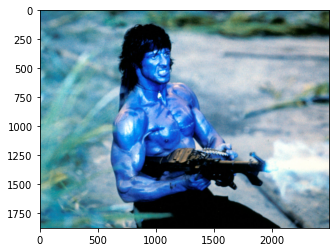

In [141]:
img = cv2.imread('rambo-1.jpg')
plt.imshow(img)
plt.show()

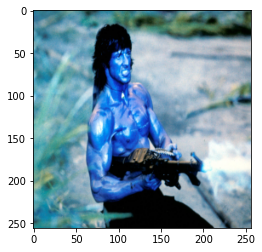

In [142]:
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
plt.imshow(resized)
plt.show()

In [143]:
inputs[0].host = np.float32(np.expand_dims(resized/255, 0))

In [144]:
def do_inference_v2(context, bindings, inputs, outputs, stream):
    # Transfer input data to the GPU.
    [cuda.memcpy_htod_async(inp.device, inp.host, stream) for inp in inputs]
    # Run inference.
    context.execute_async_v2(bindings=bindings, stream_handle=stream.handle)
    # Transfer predictions back from the GPU.
    [cuda.memcpy_dtoh_async(out.host, out.device, stream) for out in outputs]
    # Synchronize the stream
    stream.synchronize()
    print(outputs)
    # Return only the host outputs.
    return [out.host for out in outputs]

In [145]:
trt_outputs = do_inference_v2(context, bindings=bindings, inputs=inputs, outputs=outputs, stream=stream)

[Host:
[0.00560227]
Device:


In [146]:
print(trt_outputs)

[array([0.00560227], dtype=float32)]


In [147]:
print(trt_outputs[0][0])
if trt_outputs[0][0] > 0.5: 
    print(f'Predicted class is Wick')
else:
    print(f'Predicted class is Rambo')

0.0056022704
Predicted class is Rambo
